# Imports

In [1]:
import pickle
from pathlib import Path
from joblib import dump, load
from functools import partial
import copy

import anndata
import scanpy as sc
import diffxpy.api as de

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import linalg as LA

from skorch import NeuralNetClassifier
from skorch.callbacks import Callback, EpochScoring, LRScheduler, PassthroughScoring, Checkpoint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import FunctionTransformer
from sklearn.utils.estimator_checks import check_estimator
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context="paper")
import numpy as np
import scipy
import pandas as pd

import utility

In [2]:
random_state = 42
torch.manual_seed(random_state)

# Model definition

## Model
This is a logistic regression classifier, where the output labels are actually a joint labeling, of both the cell type and the tissue type of each cell.

We've called it a "sequential" classifier because in addition to the joint prediction above, we also combine the output from the joint nodes of the same cell type to get a cell type prediction score and also assess the cell type prediction alone. This is "sequential" because first we predict the (Tissue, Cell type) joint label, and then we use those predictions to also get the Cell type prediction

## Base model (Multinomial logistic regression)

In [3]:
class MultinomialLRModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        self.linear = nn.Linear(input_size, output_size)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        return self.softmax(self.linear(x))

## Exclusive Lasso Penalty

In [4]:
def exclusive_lasso_penalty(W):
    penalty = LA.norm(W, ord=1, dim=0)
    penalty= LA.norm(penalty, ord=2)
    return penalty

## Sequential classifier

In [5]:
class SequentialMultiLabelClassifier(NeuralNetClassifier):
    """
    Parameters
    ----------
    ct_group_bounds:
    ct_map:
    secondary_criterion_weight:
    lambda_clf:
    regularization:
    lambda_reg:
    """
    def __init__(self, *args,
                 ct_group_bounds=None,
                 ct_map=None,
                 secondary_criterion_weight=None,
                 lambda_clf=1.,
                 regularization=None,
                 lambda_reg=0.01,
                 **kwargs):
        super().__init__(*args, **kwargs)
        self.ct_group_bounds = ct_group_bounds
        self.ct_map = ct_map
        self.secondary_criterion_weight = secondary_criterion_weight
        self.lambda_clf = lambda_clf
        if regularization not in [None, 'l1', 'exclusive_l1']:
            raise ValueError('Invalid regularization parameter.')
        self.regularization = regularization
        self.lambda_reg = lambda_reg

    def get_ct_loss(self, y_pred, y_true):
        y_true = torch.tensor(np.vectorize(self.ct_map.get)(y_true))

        cumsum = y_pred.cumsum(1)
        groupsum = cumsum[:, self.ct_group_bounds]
        diff = torch.zeros_like(groupsum)
        diff[:, 1:] = cumsum[:, self.ct_group_bounds[:-1]]
        y_pred = groupsum - diff

        return F.cross_entropy(y_pred, y_true, weight=self.secondary_criterion_weight)
    
    def get_loss(self, y_pred, y_true, X=None, training=False):
        loss_multilabel = super().get_loss(y_pred, y_true, X=X, training=training)
        loss_celltype = torch.tensor(0.)
        if self.lambda_clf != 0.:
            loss_celltype = self.get_ct_loss(y_pred, y_true)
        loss_regularizer = torch.tensor(0.)
        if self.regularization == 'exclusive_l1':
            loss_regularizer = exclusive_lasso_penalty(self.module_.linear.weight)
        elif self.regularization == 'l1':
            loss_regularizer = self.module_.linear.weight.abs().sum()
        total_loss = loss_multilabel + self.lambda_clf * loss_celltype + self.lambda_reg * loss_regularizer
        
        prefix = 'train' if training else 'valid'
        self.history.record_batch(prefix + '_loss_ML', loss_multilabel.item())
        self.history.record_batch(prefix + '_loss_CT', loss_celltype.item())
        self.history.record_batch(prefix + '_loss_reg', loss_regularizer.item())
        
        return total_loss

## Input Transforms
Transformations that are applied to each input sample before being fed to the model

In [6]:
log_transformer = FunctionTransformer(np.log1p, validate=True)

In [7]:
FLOAT_DTYPES = (np.float64, np.float32, np.float16)

def check_non_neg(x):
    if (x < 0.).any():
        raise ValueError("Values in array must be non-negative")
    return x

class CellTotalCountNormalizer(TransformerMixin, BaseEstimator):
    def __init__(self):
        return

    def fit(self, X, y=None):
        X = check_array(X, dtype=FLOAT_DTYPES)
        X = check_non_neg(X)
        cell_totals = X.sum(axis=1)
        self.target_sum_ = np.median(cell_totals[cell_totals > 0])
        self.n_features_ = X.shape[1]
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X, dtype=FLOAT_DTYPES)
        X = check_non_neg(X)
        if X.shape[1] != self.n_features_:
            raise ValueError("Number of features in transform is different from the number of features in fit")
        
        cell_totals = X.sum(axis=1)
        cell_totals += cell_totals == 0
        cell_totals = cell_totals / self.target_sum_
        
        X = np.divide(X, cell_totals[:, None])
        return X
check_estimator(CellTotalCountNormalizer())


## Training utilities
These include callback functions and scoring functions that track performance during training

In [8]:
class SparseWeightsThresholder(Callback):
    def __init__(self, eps=1e-4):
        self.eps = eps

    def on_epoch_end(self, net, *args, **kwargs):
         with torch.no_grad():
            net.module_.linear.weight[net.module_.linear.weight.abs() < self.eps] = 0.

In [9]:
def _ct_acc_score(net, X, y, ct_bounds, ct_map):
    y_pred = net.forward(X)
    y = torch.tensor(np.vectorize(ct_map.get)(y))

    cumsum = y_pred.cumsum(1)
    groupsum = cumsum[:, ct_bounds]
    diff = torch.zeros_like(groupsum)
    diff[:, 1:] = cumsum[:, ct_bounds[:-1]]
    y_pred = groupsum - diff
    y_pred = F.log_softmax(y_pred, dim=-1)

    accuracy = (y_pred.argmax(dim=-1) == y).sum().float() / float(y.shape[0])
    accuracy = accuracy.item()
    return accuracy

def _ct_balanced_acc_score(net, X, y, ct_bounds, ct_map):
    y_pred = net.forward(X)
    y = torch.tensor(np.vectorize(ct_map.get)(y))

    cumsum = y_pred.cumsum(1)
    groupsum = cumsum[:, ct_bounds]
    diff = torch.zeros_like(groupsum)
    diff[:, 1:] = cumsum[:, ct_bounds[:-1]]
    y_pred = groupsum - diff
    y_pred = F.log_softmax(y_pred, dim=-1)
    y_pred = y_pred.argmax(dim=-1)
    
    return balanced_accuracy_score(y, y_pred)

def get_class_weights(y_train, ct_map):
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    multilabel_class_weights = torch.from_numpy(class_weights).float()
    
    y_train_ct = np.vectorize(ct_map.get)(y_train)
    celltype_class_weights = compute_class_weight('balanced', classes=np.unique(y_train_ct), y=y_train_ct)
    celltype_class_weights = torch.from_numpy(celltype_class_weights).float()
    return multilabel_class_weights, celltype_class_weights
    

def get_ct_scorers(ct_bounds, ct_map):   
    ct_acc_score_fn = partial(_ct_acc_score, ct_bounds=ct_bounds, ct_map=ct_map)
    ct_balanced_acc_score_fn = partial(_ct_balanced_acc_score, ct_bounds=ct_bounds, ct_map=ct_map)
    return ct_acc_score_fn, ct_balanced_acc_score_fn

# Evaluation & Plotting routines
Inspect the fitted model performance metrics. Also use the model weights to determine marker genes for each (cell type, tissue type) phenotype, and inspect those.

In [10]:
def eval_model(model, X_train, y_train, X_test, y_test, le):
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    print(f"train acc:         {train_acc}")
    print(f"test acc:          {test_acc}")
    y_pred = model.predict(X_test)
    test_bal_acc = balanced_accuracy_score(y_test, y_pred)
    print(f"test balanced acc: {test_bal_acc}")
    print("classification report:")
    report = classification_report(y_test, y_pred, target_names=le.classes_)
    print(report)
    return test_bal_acc

def consolidate_non_zero_features(coefs):
    print(coefs.shape[1])
    always_zero = np.ones(coefs.shape[1])
    zeros = (coefs == 0).sum(axis=0)
    always_zeros = zeros == coefs.shape[0]
    print(f"features that are always zero: {always_zeros.sum()}")
    return ~always_zeros

def check_sparsity(lr_model, label_encoder, model_name="Softmax Regression Model", figure_savefile=None):
    # overall sparsity
    n_weights = np.prod(lr_model.coef_.shape)
    overall_sparsity = (n_weights - np.count_nonzero(lr_model.coef_)) / n_weights
    print(f"Overall sparsity: {overall_sparsity}")
    
    sparsity = (lr_model.coef_.shape[1] - np.count_nonzero(lr_model.coef_, axis=1)) / lr_model.coef_.shape[1]
    print("fraction of weights that are zero:")
    for class_name, sparsity in zip(label_encoder.inverse_transform(lr_model.classes_), sparsity):
        print(f"{class_name}: {sparsity}")

    non_zero_selector = consolidate_non_zero_features(lr_model.coef_)
    n_always_zero = (~non_zero_selector).sum()
    
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.heatmap(lr_model.coef_[:, non_zero_selector], center=0, ax=ax)
    # We want to show all ticks...
    ax.set_yticks(np.arange(len(lr_model.classes_)))
    # ... and label them with the respective list entries
    ax.set_yticklabels(label_encoder.inverse_transform(lr_model.classes_), rotation=0)
    ax.set_xlabel("Gene number")
    ax.set_ylabel("Class")
    if n_always_zero > 0:
        ax.set_title(f'Fitted Coefficients for {model_name}\n{n_always_zero} features are always zero')
    else:
        ax.set_title(f'Fitted Coefficients for {model_name}')
    if figure_savefile is not None:
        plt.savefig(f'{figure_savefile}.png')
        plt.savefig(f'{figure_savefile}.pdf')
    return overall_sparsity

class SkorchLRAdapter:
    def __init__(self, skorch_lr_model):
        self.coef_ = skorch_lr_model.module_.linear.weight.detach().numpy()
        self.classes_ = skorch_lr_model.classes_

def find_exclusive_model_weights(weights, class_names, feature_symbols, k=20, verbose=False):
    all_features_pos = []
    all_features_pos_class_names = []
    for class_value, class_name in zip(range(weights.shape[0]), class_names):
        top_features_abs = (-np.abs(weights[class_value, :])).argsort()[:k]
        top_features_pos = (-np.maximum(0., weights[class_value, :])).argsort()[:k]
        top_features_neg = (np.minimum(0., weights[class_value, :])).argsort()[:k]

        all_features_pos.append(set(feature_symbols.iloc[top_features_pos, 0]))
        all_features_pos_class_names.append(class_name)
        
        tmp_df = feature_symbols.assign(weight = weights[class_value, :])
        if verbose:
            print(class_name)
            print(f"Top features (abs):")
            print(tmp_df.iloc[top_features_abs, :])
            print()
            print(f"Top features (pos):")
            print(tmp_df.iloc[top_features_pos, :])
            print()
            print(f"Top features (neg):")
            print(tmp_df.iloc[top_features_neg, :])
            print()
            print()
            print()
    
    exclusive_results = {}
    for i, class_label in enumerate(all_features_pos_class_names):
        exclusive = all_features_pos[i].difference(set().union(*(all_features_pos[:i] + all_features_pos[i+1:])))
        exclusive_results[class_label] = list(exclusive)
        if verbose:
            print(class_label)
            print(exclusive)
    
    exclusive_lasso_result_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in exclusive_results.items() ]))
    return exclusive_lasso_result_df

def get_exclusive_model_weights_for_gsea(weights, class_names, feature_symbols, k=20, verbose=False):
    all_features_pos = []
    all_features_pos_scores = []
    all_features_pos_class_names = []
    for class_value, class_name in zip(range(weights.shape[0]), class_names):
        top_features_abs = (-np.abs(weights[class_value, :])).argsort()[:k]
        top_features_pos = (-np.maximum(0., weights[class_value, :])).argsort()[:k]
        top_features_neg = (np.minimum(0., weights[class_value, :])).argsort()[:k]

        tmp_df = feature_symbols.assign(weight = weights[class_value, :])
        all_features_pos.append(set(feature_symbols.iloc[top_features_pos, 0]))
        all_features_pos_scores.append(tmp_df.iloc[top_features_pos, :])
        all_features_pos_class_names.append(class_name)
        
        if verbose:
            print(class_name)
            print(f"Top features (abs):")
            print(tmp_df.iloc[top_features_abs, :])
            print()
            print(f"Top features (pos):")
            print(tmp_df.iloc[top_features_pos, :])
            print()
            print(f"Top features (neg):")
            print(tmp_df.iloc[top_features_neg, :])
            print()
            print()
            print()
    
    exclusive_results = {}
    exclusive_scores = {}
    for i, class_label in enumerate(all_features_pos_class_names):
        exclusive = all_features_pos[i].difference(set().union(*(all_features_pos[:i] + all_features_pos[i+1:])))
        exclusive = list(exclusive)
        exclusive_results[class_label] = exclusive
        
        score_df = all_features_pos_scores[i]
        score_df = score_df[score_df['symbol'].isin(exclusive)]
        exclusive_scores[class_label] = score_df
        if verbose:
            print(class_label)
            print(exclusive)
    
    exclusive_lasso_result_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in exclusive_results.items() ]))
    return exclusive_lasso_result_df, exclusive_scores

def inspect_fitted_model(out_dir, regularization, fitted_model, adata, label_encoder, random_state):
    model_reg_plot_string = ""
    if regularization == 'l1':
        model_reg_plot_string = "L1 Regularized "
    elif regularization == 'exclusive_l1':
        model_reg_plot_string = "Exclusive L1 Regularized "
    model_name = f"{model_reg_plot_string}Softmax Regression Model"
    sparsity = check_sparsity(SkorchLRAdapter(fitted_model['net']), label_encoder,
                              model_name=model_name,
                              figure_savefile=out_dir / "coef")
    dump(fitted_model, out_dir / 'model.joblib')
 

    weights = fitted_model['net'].module_.linear.weight.detach().numpy()
    feature_symbols = adata.var[['symbol']]
    exclusive_weights_df = find_exclusive_model_weights(weights, label_encoder.classes_, feature_symbols)
    exclusive_weights_df.to_pickle(out_dir / 'exclusive_weights_table.pkl')
    exclusive_weights_df.to_latex(out_dir / 'exclusive_weights_table.tex', index=False, na_rep="", caption="")

    generate_model_gene_module_reports(adata, exclusive_weights_df, model_name, out_dir / "model_gene_module_reports", random_state)
    
    # De enrichment:
    _, exclusive_scores = get_exclusive_model_weights_for_gsea(weights, label_encoder.classes_, feature_symbols)
    enrich_folder = out_dir / "enrich"
    enrich_folder.mkdir(exist_ok=True, parents=True)
    for label, score_df in exclusive_scores.items():
        save_file = enrich_folder / f"{label}_GO_enrich.tex"
        utility.do_enrich(score_df['symbol'].tolist(), score_df['weight'], all_genes_info['symbol'], save_file)
    return sparsity, exclusive_weights_df

In [11]:
def get_module_score_violin(adata, genes, celltype, tissue, model_name, save_path):
    # Cell identity embedding plots
    combined_key = f"{celltype},{tissue}"
    adata.obs[f"is {combined_key}"] = pd.Categorical((adata.obs_vector('celltype') == celltype) & (adata.obs_vector('tissue') == tissue))

    # Gene-group score embedding plot
    if np.array_equal(adata.var['symbol'], adata.var.index):
        # index is symbols too, no need to use ensembl
        score_genes = genes
    else:
        score_genes = [ adata.var.loc[adata.var['symbol'] == symb, 'ens'].iloc[0] for symb in genes]
    
    score_name = f'{combined_key} module score'
    sc.tl.score_genes(adata, score_genes, score_name=score_name)

    hits = adata.obs[adata.obs[f'is {combined_key}'] == True][f'{combined_key} module score']
    others = adata.obs[adata.obs[f'is {combined_key}'] == False][f'{combined_key} module score']
    hits_mean = hits.mean()
    others_mean = others.mean()
    hits_size = len(hits)
    others_size = len(others)
    
    # Statistical testing
    test_stat, pval = stats.ttest_ind(hits, others, equal_var=False, alternative='greater')
    significance = ""
    if pval <= 0.001:
        significance = "***"
    elif pval <= 0.01:
        significance = "**"
    elif pval <= 0.05:
        significance = "*"
    else:
        significance = "ns"
    significance = f"{significance} $p$={pval:0.3e}"
    
    fig, ax = plt.subplots()
    sns.violinplot(x=f'is {combined_key}', y=f'{combined_key} module score', data=adata.obs, order=[True, False], ax=ax)
    fig.suptitle(f"{model_name}\n{combined_key} module score", y=1.1)
    subtitle = f"Diff. of means (True - False): {hits_mean - others_mean:0.2f}"
    print(subtitle)
    ax.set_title(subtitle)
    xlabels = [item.get_text() for item in ax.get_xticklabels()]
    xlabels[0] = f"{xlabels[0]} (n={hits_size})"
    xlabels[1] = f"{xlabels[1]} (n={others_size})"
    ax.set_xticklabels(xlabels)
    ax.set_xlabel(f"I{ax.get_xlabel()[1:]}?")
    # statistical annotation
    pad = adata.obs[f'{combined_key} module score'].max() * 0.1
    y_min, y_max = ax.get_ylim()
    ax.set_ylim(y_min, y_max + (5*pad))
    x1, x2 = 0, 1
    
    y, h, col = adata.obs[f'{combined_key} module score'].max() + (2*pad), pad, 'k'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.0, c=col)
    ax.text((x1+x2)*.5, y+h, significance, ha='center', va='bottom', color=col)
    ax.text((x1+x2)*.5, y+h-(0.2*h), f"$t$-stat={test_stat:0.3f}", ha='center', va='top', color=col)
    
    plt.savefig(f"{save_path}.png", bbox_inches="tight")
    plt.savefig(f"{save_path}.pdf", bbox_inches="tight")
    plt.close()
#     plt.show()

def generate_model_gene_module_violin(adata, gene_df, model_name, folder, random_state, max_cells=50000):
    if adata.shape[0] > max_cells:
        print(f"More than {max_cells} cells, subsampling...")
        adata = sc.pp.subsample(adata, n_obs=max_cells, random_state=random_state, copy=True)
    if not isinstance(folder, Path):
        folder = Path(folder)
    folder.mkdir(parents=True, exist_ok=True)
    for gene_module in gene_df.columns:
        print(gene_module)
        genes = gene_df[gene_module].dropna().tolist()
        if len(genes) == 0:
            print('no exlusive genes for this module')
            continue
        print(f"genes: {genes}")
        celltype, tissue = gene_module.split(',')
        report_path = folder / f"{model_name} {celltype}_{tissue}"
        get_module_score_violin(adata, genes, celltype, tissue, model_name, report_path)  

def gene_expression_report(adata, genes, celltype, tissue, model_name, save_path):
    if 'X_umap' not in adata.obsm:
        print("computing umap...")
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)
        adata.raw = adata
        sc.pp.scale(adata)
        sc.tl.pca(adata)
        sc.pp.neighbors(adata, n_pcs=50)
        sc.tl.umap(adata)
        print("done.")
    
    n_plots = 4 + len(genes)
    n_cols = 5
    n_rows = int(np.ceil(n_plots / n_cols))
    width = 10
    height = 2 * n_rows
    fig, all_axs = plt.subplots(n_rows, n_cols, figsize=(width, height), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})

    # Cell identity embedding plots
    combined_key = f"{celltype},{tissue}"
    adata.obs[f"is_{combined_key}"] = pd.Categorical((adata.obs_vector('celltype') == celltype) & (adata.obs_vector('tissue') == tissue))
    adata.uns[f'is_{combined_key}_colors'] = ['grey', 'red']

    adata.obs[f'is_{celltype}'] = pd.Categorical(adata.obs_vector('celltype') == celltype)
    adata.uns[f'is_{celltype}_colors'] = ['grey', 'red']
    
    adata.obs[f'is_{tissue}'] = pd.Categorical(adata.obs_vector('tissue') == tissue)
    adata.uns[f'is_{tissue}_colors'] = ['grey', 'red']

    sc.pl.umap(adata, color=f'is_{combined_key}', title=[combined_key], show=False, ax=all_axs[0, 0])
    sc.pl.umap(adata, color=f'is_{celltype}', title=[celltype], show=False, ax=all_axs[0, 1])
    sc.pl.umap(adata, color=f'is_{tissue}', title=[tissue], show=False, ax=all_axs[0, 2])
    for ax in all_axs[0, :3]:
        ax.get_legend().remove()

    # Gene-group score embedding plot
    if np.array_equal(adata.var['symbol'], adata.var.index):
        # index is symbols too, no need to use ensembl
        score_genes = genes
    else:
        score_genes = [ adata.var.loc[adata.var['symbol'] == symb, 'ens'].iloc[0] for symb in genes]
    
    score_name = 'Module score'
    sc.tl.score_genes(adata, score_genes, score_name=score_name)
    sc.pl.umap(adata, color=score_name, show=False, ax=all_axs[0, 3], color_map="viridis")
    
    
    # All gene embedding plots
    for i, gene in enumerate(genes):
        row_idx = ((i + 4) // n_cols)
        col_idx = (i + 4) % n_cols
        sc.pl.umap(adata, color=gene, gene_symbols='symbol', show=False, ax=all_axs[row_idx, col_idx], color_map="viridis")
    
    for i in range(n_cols):
        for j in range(n_rows - 1):
            all_axs[j, i].set_xlabel(None)
    for i in range(1, n_cols):
        for j in range(n_rows):
            all_axs[j, i].set_ylabel(None)
    for i in range(4 + len(genes), n_cols*n_rows):
        row_idx = i // n_cols
        col_idx = i % n_cols
        fig.delaxes(all_axs[row_idx][col_idx])
#     fig.suptitle(f"{combined_key} gene module report for {model_name}", y=0.92, fontsize='x-large')
    plt.savefig(f"{save_path}_150dpi.png", dpi=150)
    plt.savefig(f"{save_path}_200dpi.png", dpi=200)
#     plt.savefig(f"{save_path}_300dpi.png", dpi=300)
#     plt.savefig(f"{save_path}.pdf")
    plt.close()

def generate_model_gene_module_reports(adata, gene_df, model_name, folder, random_state, max_cells=50000):
    if adata.shape[0] > max_cells:
        print(f"More than {max_cells} cells, subsampling...")
        adata = sc.pp.subsample(adata, n_obs=max_cells, random_state=random_state, copy=True)
    if not isinstance(folder, Path):
        folder = Path(folder)
    folder.mkdir(parents=True, exist_ok=True)
    for gene_module in gene_df.columns:
        print(gene_module)
        genes = gene_df[gene_module].dropna().tolist()
        if len(genes) == 0:
            print('no exlusive genes for this module')
            continue
        print(f"genes: {genes}")
        celltype, tissue = gene_module.split(',')
        report_path = folder / f"{celltype}_{tissue}"
        gene_expression_report(adata, genes, celltype, tissue, model_name, report_path)  



# Analysis pipeline
The "main" or "driver" code that puts all the above together.

In [12]:
def fit_checkpointed_model(X_train, y_train, X_test, y_test, le, checkpoint_dir, regularization, lambda_reg,
                           ct_bounds, ct_map, multilabel_class_weights, balanced_acc, ct_acc, ct_balanced_acc,
                           ct_acc_score_fn, ct_balanced_acc_score_fn, celltype_class_weights,
                           learning_rate, lr_plateau_factor=0.5, optimizer=torch.optim.Adam, epochs=200):
    cp = Checkpoint(dirname=checkpoint_dir)
    net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                         module__input_size=X_train.shape[1],
                                         module__output_size=len(le.classes_),
                                         regularization=regularization,
                                         ct_group_bounds=ct_bounds,
                                         ct_map=ct_map,
                                         criterion__weight=multilabel_class_weights,
                                         max_epochs=epochs,
                                         optimizer=optimizer,
                                         lr=learning_rate,
                                         iterator_train__shuffle=True,
                                         callbacks=[('balanced_acc', balanced_acc),
                                                    ('celltype_acc', ct_acc),
                                                    ('celltype_balanced_acc', ct_balanced_acc),
                                                    ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                                 factor=lr_plateau_factor, verbose=True)),
                                                    ('train_loss_ML', PassthroughScoring(name='train_loss_ML', on_train=True)),
                                                    ('train_loss_CT', PassthroughScoring(name='train_loss_CT', on_train=True)),
                                                    ('sparse_thresholder', SparseWeightsThresholder()),
                                                    ('checkpoint', cp),
                                                   ],
                                         lambda_clf=0.,
                                         secondary_criterion_weight=celltype_class_weights,
                                         lambda_reg=lambda_reg) #

    pipe = Pipeline([
            ('normalize_total', CellTotalCountNormalizer()),
            ('log', log_transformer),
            ('scale', StandardScaler()),
            ('net', net),
        ])
    pipe.fit(X_train, y_train)
    pipe['net'].initialize()
    pipe['net'].load_params(checkpoint=cp)
    test_balanced_acc = eval_model(pipe, X_train, y_train, X_test, y_test, le)
    test_ct_acc = ct_acc_score_fn(net, np.asarray(X_test), y_test)
    print(f"test CT acc: {test_ct_acc}")
    test_ct_balanced_acc = ct_balanced_acc_score_fn(net, np.asarray(X_test), y_test)
    print(f"test CT balanced acc: {test_ct_balanced_acc}")
    print()
    return pipe, test_balanced_acc 

def build_ct_map(ct_group_bounds):
    ct_map = {}
    bound_idx = 0
    for i in range(ct_group_bounds[-1] + 1):
        if i > ct_group_bounds[bound_idx]:
            bound_idx += 1
        ct_map[i] = bound_idx
    return ct_map

def run_analysis_for_regularization(regularization, X_train, X_test, y_train, y_test, le, adata, all_genes_info, result_folder, random_state, cell_types_list=None, n_jobs=-1):
    # if not isinstance(result_folder, Path):
    #     result_folder = Path(result_folder)
    # best_settings_dir = result_folder / 'best_settings'
    # best_settings_dir.mkdir(parents=True, exist_ok=True)
    # extra_pen_dir = result_folder / 'extra_penalty'
    # extra_pen_dir.mkdir(parents=True, exist_ok=True)
    
    # Set up evaluation metrics
    ct_bounds = []
    ct_classes = [s.split(',')[0] for s in le.classes_]
    if len(np.unique(ct_classes)) > 1:
        cur_ct = ct_classes[0]
        for i in range(len(ct_classes)):
            if ct_classes[i] != cur_ct:
                ct_bounds.append(i - 1)
                cur_ct = ct_classes[i] 
    ct_bounds.append(len(ct_classes) - 1)
    ct_map = build_ct_map(ct_bounds)

    ct_acc_score_fn, ct_balanced_acc_score_fn = get_ct_scorers(ct_bounds, ct_map)
    multilabel_class_weights, celltype_class_weights = get_class_weights(y_train, ct_map)
    # Balanced joint accuracy
    balanced_acc = EpochScoring(name='balanced_acc', scoring='balanced_accuracy', lower_is_better=False)
    # Cell type accuracy
    ct_acc = EpochScoring(name='CT_acc', scoring=ct_acc_score_fn, lower_is_better=False)
    # Balanced cell type accuracy
    ct_balanced_acc = EpochScoring(name='CT_balanced_acc', scoring=ct_balanced_acc_score_fn, lower_is_better=False)

    # Run a quick cross validated grid-search to get the best hyperparemeters
    param_grid = {
        'net__max_epochs': [10, 20, 100],
        'net__lr': [0.01, 0.001],
        'net__optimizer': [torch.optim.Adam],
        'net__callbacks__lr_scheduler__factor': [0.5],
        'net__lambda_clf': [0.],
        'net__lambda_reg': [0., 0.001, 0.01, 0.1],
        'net__regularization': [regularization]
    }
    #     # Just for debugging
    param_grid = {
        'net__max_epochs': [1],
        'net__lr': [0.01],
        'net__optimizer': [torch.optim.Adam],
        'net__callbacks__lr_scheduler__factor': [0.5],
        'net__lambda_clf': [0.],
        'net__lambda_reg': [0.01],
        'net__regularization': [regularization]
    }

    net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                         module__input_size=X_train.shape[1],
                                         module__output_size=len(le.classes_),
                                         ct_group_bounds=ct_bounds,
                                         ct_map=ct_map,
                                         criterion__weight=multilabel_class_weights,
                                         iterator_train__shuffle=True,
                                         callbacks=[('balanced_acc', balanced_acc),
                                                    ('celltype_acc', ct_acc),
                                                    ('celltype_balanced_acc', ct_balanced_acc),
                                                    ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                                 factor=0.5, verbose=True)),
                                                    ('train_loss_ML', PassthroughScoring(name='train_loss_ML', on_train=True)),
                                                    ('train_loss_CT', PassthroughScoring(name='train_loss_CT', on_train=True)),
                                                    ('sparse_thresholder', SparseWeightsThresholder()),
                                                   ],
                                         secondary_criterion_weight=celltype_class_weights)
    pipe = Pipeline([
            ('normalize_total', CellTotalCountNormalizer()),
            ('log', log_transformer),
            ('scale', StandardScaler()),
            ('net', net),
        ])

    gs = GridSearchCV(pipe, param_grid, refit=True, cv=3, scoring='balanced_accuracy', verbose=4, n_jobs=n_jobs)
    gs.fit(X_train, y_train)
    dump(gs, result_folder / 'quick_gridsearch.joblib')
    with open(result_folder / "quick_gridsearch_best_params.txt", 'w') as text_file:
        text_file.write(str(gs.best_params_))
    print(gs.best_params_)

    results = {}
    # Fit a checkpointed model with the best parameters:
    pipe, acc = fit_checkpointed_model(X_train, y_train, X_test, y_test, le, result_folder / 'checkpoints', regularization, gs.best_params_['net__lambda_reg'],
                                                 ct_bounds, ct_map, multilabel_class_weights, balanced_acc, ct_acc, ct_balanced_acc, ct_acc_score_fn, ct_balanced_acc_score_fn, celltype_class_weights,
                                                 gs.best_params_['net__lr'], gs.best_params_['net__callbacks__lr_scheduler__factor'], gs.best_params_['net__optimizer'], epochs=1)
    results['acc'] = acc
    sparsity, exclusive_weights_df = inspect_fitted_model(result_folder, regularization, pipe, adata, le, random_state)
    results['sparsity'] = sparsity
    results['exclusive_weights_df'] = exclusive_weights_df
    
    with open(result_folder / 'results_dict.pickle', 'wb') as f:
        pickle.dump(results, f)
    return pipe, results

def get_X_y_data(adata, random_state=None, min_label_count=100):
    adata.obs['celltype_and_tissue'] = adata.obs[['celltype', 'tissue']].agg(','.join, axis=1)
    
    label_counts = adata.obs['celltype_and_tissue'].value_counts()
    labels_to_keep = label_counts[label_counts >= min_label_count].index
    adata = adata[adata.obs['celltype_and_tissue'].isin(labels_to_keep)]
    
    X = adata.X
    y = adata.obs['celltype_and_tissue']
    le = LabelEncoder()
    y = le.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=random_state)
    return le, X_train, X_test, y_train, y_test

# Run analysis pipeline (usually, called once per dataset)
def run_analysis_pipeline(adata, all_genes_info, result_folder, random_state, cell_types_list=None, n_jobs=-1, min_label_count=100, de_markers_df=None):
    if not isinstance(result_folder, Path):
        result_folder = Path(result_folder)
        
    l1_dir = result_folder / 'L1'
    l1_dir.mkdir(parents=True, exist_ok=True)
    ex_l1_dir = result_folder / 'Exclusive_L1'
    ex_l1_dir.mkdir(parents=True, exist_ok=True)
    
    fig_folder = result_folder / "regularization_comparison_figs"
    fig_folder.mkdir(exist_ok=True)
    
    # Set up data for ML model consumption
    if cell_types_list is None:
        cell_types_list = adata.obs["celltype"].unique()
    le, X_train, X_test, y_train, y_test = get_X_y_data(adata[adata.obs["celltype"].isin(cell_types_list)],
                                                        random_state=random_state, min_label_count=min_label_count)
    if isinstance(X_train, scipy.sparse.spmatrix):
        X_train, X_test = X_train.todense(), X_test.todense()
    X_train, X_test = np.asarray(X_train), np.asarray(X_test)
    
    # L1
    l1_model, l1_results = run_analysis_for_regularization('l1', X_train, X_test, y_train, y_test, le, adata, all_genes_info, l1_dir, random_state, cell_types_list, n_jobs)
    # Exclusive L1
    ex_l1_model, ex_l1_results = run_analysis_for_regularization('exclusive_l1', X_train, X_test, y_train, y_test, le, adata, all_genes_info, ex_l1_dir, random_state, cell_types_list, n_jobs)
    
    # Compile results
    res_df = {
        'Regularization': ['Exclusive L1', 'L1'],
        'Test accuracy': [ex_l1_results['acc'],
                          l1_results['acc'],
                         ],
        'Sparsity': [ex_l1_results['sparsity'],
                     l1_results['sparsity'],
                    ],
    }
    res_df = pd.DataFrame(res_df)
    
    # Test accuracy
    with sns.axes_style("whitegrid"):
        fig, ax = plt.subplots(figsize=(4, 1.5))
        sns.barplot(y="Regularization", x="Test accuracy", data=res_df, order=['L1', 'Exclusive L1'], orient='h', ax=ax)
        ax.set_title('Model Accuracy')
        ax.set_xlim((0, 1))
        filename = "test_accuracy"
        plt.savefig(fig_folder / f"{filename}.png", bbox_inches="tight")
        plt.savefig(fig_folder / f"{filename}.pdf", bbox_inches="tight")
        plt.show()
    
    # Sparsity
    with sns.axes_style("whitegrid"):
        fig, ax = plt.subplots(figsize=(4, 1.5))
        sns.barplot(y="Regularization", x="Sparsity", data=res_df, order=['L1', 'Exclusive L1'], orient='h', ax=ax)
        ax.set_title('Model Sparsity')
        filename = "model_sparsity"
        plt.savefig(fig_folder / f"{filename}.png", bbox_inches="tight")
        plt.savefig(fig_folder / f"{filename}.pdf", bbox_inches="tight")
        plt.show()
    
    # Marker yeilds
    marker_rec_arr = [
        l1_results['exclusive_weights_df'].count().append(pd.Series({'Model': 'L1'})),
        ex_l1_results['exclusive_weights_df'].count().append(pd.Series({'Model': 'Exclusive L1'})),
    ]
    hue_order = ['L1', 'Exclusive L1']
    if de_markers_df is not None:
        marker_rec_arr.append(de_markers_df.count().append(pd.Series({'Model': 'DE'})))
        hue_order.insert(0, 'DE')
    marker_df = pd.DataFrame.from_records(marker_rec_arr)
    marker_df = pd.melt(marker_df, id_vars=['Model'], var_name = "Phenotype", value_name="Exclusive marker count")
    marker_df['Phenotype'] = marker_df['Phenotype'].str.replace('_',' ')
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.barplot(x="Phenotype",
                     y="Exclusive marker count",
                     hue="Model",
                     data=marker_df,
                     hue_order=hue_order,
                ax=ax,
                     )
    ax.set_title('Marker Exclusivity')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    # ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
    ax.legend(loc='upper right', bbox_to_anchor=(1.01, -0.35))
    filename = "marker_exclusivity"
    plt.savefig(fig_folder / f"{filename}.png", bbox_inches="tight")
    plt.savefig(fig_folder / f"{filename}.pdf", bbox_inches="tight")
    plt.show()
    print("DONE.")

# Runs

## Human Data

In [ ]:
result_folder = Path("results/human")
result_folder.mkdir(parents=True, exist_ok=True)

In [ ]:
adata = utility.load_all_human_data("data/hubmap/", "data/van_der_Wijst_PBMC/count_matrices_per_lane/")
all_genes_info = adata.var
print(f"Initial data shape: {adata.shape}")
old_n_genes = adata.shape[1]
adata, hvg_genes = utility.filter_hvg(adata)
print(f"After hvg shape: {adata.shape}")
print(f"\tRemoved {old_n_genes - adata.shape[1]} genes")

Cell type subset

In [ ]:
cell_types_list = ['T Cell', 'Fibroblast', 'B Cell', 'NK Cell']

### Run Differential Expression for comparison

In [ ]:
adata_de = adata[adata.obs["celltype"].isin(cell_types_list)]
sc.pp.normalize_total(adata_de, target_sum=1e4)
sc.pp.log1p(adata_de)
sc.pp.highly_variable_genes(adata_de, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_de.obs['celltype_and_tissue'] = adata_de.obs[['celltype', 'tissue']].agg(','.join, axis=1)
label_counts = adata_de.obs['celltype_and_tissue'].value_counts()
min_label_count = 100
labels_to_keep = label_counts[label_counts >= min_label_count].index
adata_de = adata_de[adata_de.obs['celltype_and_tissue'].isin(labels_to_keep)]
adata_de.raw = adata_de
sc.tl.rank_genes_groups(adata_de, 'celltype_and_tissue', method='wilcoxon')

In [ ]:
phenotypes = adata_de.obs['celltype_and_tissue'].unique()
de_top_genes = []
for i, pheno in enumerate(phenotypes):
    dedf = sc.get.rank_genes_groups_df(adata_de, group=pheno, gene_symbols='symbol', log2fc_min=0.)
    top_genes = dedf['symbol'][:20].tolist()
    de_top_genes.append(set(top_genes))

exclusive_results = {}
for i, class_label in enumerate(phenotypes):
    exclusive = de_top_genes[i].difference(set().union(*(de_top_genes[:i] + de_top_genes[i+1:])))
    exclusive_results[class_label] = list(exclusive)
    print(class_label)
    print(exclusive)

de_exclusive_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in exclusive_results.items() ]))

### Run Exclusive L1 classifier framework

In [ ]:
run_analysis_pipeline(adata, all_genes_info, result_folder, random_state, cell_types_list=cell_types_list, n_jobs=6, de_markers_df=de_exclusive_df)

## Mouse Data

In [13]:
result_folder = Path("results/mouse")
result_folder.mkdir(parents=True, exist_ok=True)

In [14]:
adata = utility.load_tabula_muris_data("data/tabula_muris", ['Lung', 'Limb_Muscle', 'Fat', 'Spleen'])
all_genes_info = adata.var
print(f"Initial data shape: {adata.shape}")
old_n_genes = adata.shape[1]
adata, hvg_genes = utility.filter_hvg(adata)
print(f"After hvg shape: {adata.shape}")
print(f"\tRemoved {old_n_genes - adata.shape[1]} genes")

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


../hubmap/data/tabula_muris/FACS/Lung-counts.csv
(1716, 23433)
(1716, 23433)
../hubmap/data/tabula_muris/FACS/Limb_Muscle-counts.csv
(1090, 23433)
(1090, 23433)
../hubmap/data/tabula_muris/FACS/Fat-counts.csv
(4967, 23433)
(4967, 23433)
../hubmap/data/tabula_muris/FACS/Spleen-counts.csv
(1697, 23433)
(1697, 23433)


Trying to set attribute `.var` of view, copying.


Initial data shape: (9328, 23433)
After hvg shape: (9328, 5127)
	Removed 18306 genes


Cell type subset

In [15]:
cell_types_list = ['B cell', 'T cell', 'natural killer cell']

### Run Differential Expression for comparison

In [16]:
adata_de = adata[adata.obs["celltype"].isin(cell_types_list)]
sc.pp.normalize_total(adata_de, target_sum=1e4)
sc.pp.log1p(adata_de)
sc.pp.highly_variable_genes(adata_de, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_de.obs['celltype_and_tissue'] = adata_de.obs[['celltype', 'tissue']].agg(','.join, axis=1)
label_counts = adata_de.obs['celltype_and_tissue'].value_counts()
min_label_count = 100
labels_to_keep = label_counts[label_counts >= min_label_count].index
adata_de = adata_de[adata_de.obs['celltype_and_tissue'].isin(labels_to_keep)]
adata_de.raw = adata_de
sc.tl.rank_genes_groups(adata_de, 'celltype_and_tissue', method='wilcoxon')

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... storing 'celltype' as categorical
... storing 'cell_ontology_id' as categorical
... storing 'mouse.id' as categorical
... storing 'mouse.sex' as categorical
... storing 'plate.barcode' as categorical
... storing 'subtissue' as categorical
... storing 'tissue' as categorical
... storing 'celltype_and_tissue' as categorical


In [17]:
phenotypes = adata_de.obs['celltype_and_tissue'].unique()
de_top_genes = []
for i, pheno in enumerate(phenotypes):
    dedf = sc.get.rank_genes_groups_df(adata_de, group=pheno, gene_symbols='symbol', log2fc_min=0.)
    top_genes = dedf['symbol'][:20].tolist()
    de_top_genes.append(set(top_genes))

exclusive_results = {}
for i, class_label in enumerate(phenotypes):
    exclusive = de_top_genes[i].difference(set().union(*(de_top_genes[:i] + de_top_genes[i+1:])))
    exclusive_results[class_label] = list(exclusive)
    print(class_label)
    print(exclusive)

de_exclusive_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in exclusive_results.items() ]))

T cell,Fat
{'Bend4', 'Ramp3', 'Cd226', '2610019F03Rik', 'Abcb9'}
B cell,Fat
{'Ltf', 'Zc3h10', 'Neil1', 'Cdt1', 'Slc37a2', 'Cenpa', 'Cx3cr1', 'Krt15', 'Irf4', 'Chga', 'Mapk11', 'Camp', 'Ins1', 'Cd274', 'Cables2', 'Cpm', 'Zkscan14', 'Krt5', '5430427O19Rik'}
T cell,Spleen
{'Folr4', 'Sla2', 'Slc2a4rg-ps', 'Tgtp1', 'Sit1'}
B cell,Spleen
{'Haao', 'Bfsp2', '1700030K09Rik', 'Dennd3', 'Srpk3', 'Chst3', 'Pik3r4', 'Edaradd', 'Arid3b', 'Kmo', 'Emid1', 'BC035044', 'Fam129c', 'Krt8', 'Dtx1', 'Plp1', 'Fcrl5', 'Ell3', 'Cnr2'}


### Run Exclusive L1 classifier framework

Trying to set attribute `.obs` of view, copying.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:   10.6s finished


  epoch    CT_acc    CT_balanced_acc    balanced_acc    train_loss    train_loss_CT    train_loss_ML    valid_acc    valid_loss     dur
-------  --------  -----------------  --------------  ------------  ---------------  ---------------  -----------  ------------  ------
      1    0.9815             0.9872          0.7332        2.9450           0.0000           0.8826       0.7222        3.0110  0.1175
{'net__callbacks__lr_scheduler__factor': 0.5, 'net__lambda_clf': 0.0, 'net__lambda_reg': 0.01, 'net__lr': 0.01, 'net__max_epochs': 1, 'net__optimizer': <class 'torch.optim.adam.Adam'>, 'net__regularization': 'l1'}
  epoch    CT_acc    CT_balanced_acc    balanced_acc    train_loss    train_loss_CT    train_loss_ML    valid_acc    valid_loss    cp     dur
-------  --------  -----------------  --------------  ------------  ---------------  ---------------  -----------  ------------  ----  ------
      1    0.9656             0.9674          0.7576        2.9488           0.0000           

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


done.


... storing 'celltype' as categorical
... storing 'cell_ontology_id' as categorical
... storing 'free_annotation' as categorical
... storing 'mouse.id' as categorical
... storing 'mouse.sex' as categorical
... storing 'plate.barcode' as categorical
... storing 'subtissue' as categorical
... storing 'tissue' as categorical


B cell,Spleen
genes: ['Haao', 'Bfsp2', 'Zfp94', '1700030K09Rik', 'Rapgef3', 'Dennd3', 'Tacstd2', 'A230108P19Rik', 'Pigr', 'Chst3', 'Pik3r4', 'Tmem199', 'Gpm6a', 'Fam55b', 'Edaradd', 'BC035044', 'Fam129c', 'Tspan1', 'Il24', 'Cnr2']
T cell,Fat
genes: ['Fbxo32', 'Tnfsf11', 'Gm19557', 'Itpk1', 'Ccne1', 'A230020J21Rik', 'Aqp3', 'Fasl', 'D18Ertd653e', 'Pik3r5', '2610019F03Rik', 'Lime1', 'Camk4', 'Tigit', '1190002N15Rik', 'Bend4', 'Txk', 'Cd96', 'Ramp3', 'Tnfrsf10b']
T cell,Spleen
genes: ['BC147527', 'Ifit2', 'Slc12a7', 'Tgtp1', 'Tmem149', 'Slfn1', 'Rgs3', 'Folr4', 'Dapl1', 'Ptger2', 'Gm17455', 'Cd6', 'Cst7', 'Gpr68', 'Cd160', 'Il18r1', 'Podnl1', 'Cd4', 'Cd5', 'Gm14446']
0.09058975
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.09301929
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIG

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:    3.8s finished


  epoch    CT_acc    CT_balanced_acc    balanced_acc    train_loss    train_loss_CT    train_loss_ML    valid_acc    valid_loss     dur
-------  --------  -----------------  --------------  ------------  ---------------  ---------------  -----------  ------------  ------
      1    0.8280             0.8722          0.6324        1.3958           0.0000           1.3252       0.5767        1.8171  0.1037
{'net__callbacks__lr_scheduler__factor': 0.5, 'net__lambda_clf': 0.0, 'net__lambda_reg': 0.01, 'net__lr': 0.01, 'net__max_epochs': 1, 'net__optimizer': <class 'torch.optim.adam.Adam'>, 'net__regularization': 'exclusive_l1'}
  epoch    CT_acc    CT_balanced_acc    balanced_acc    train_loss    train_loss_CT    train_loss_ML    valid_acc    valid_loss    cp     dur
-------  --------  -----------------  --------------  ------------  ---------------  ---------------  -----------  ------------  ----  ------
      1    0.8307             0.8740          0.6180        1.6107           0.0000 

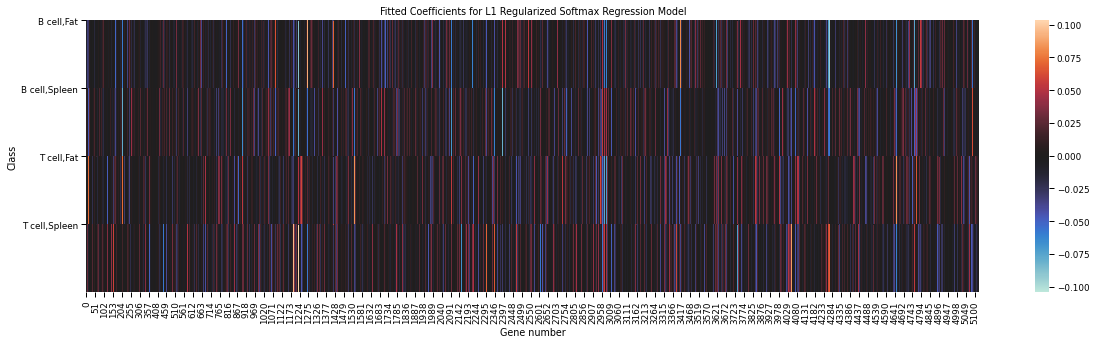

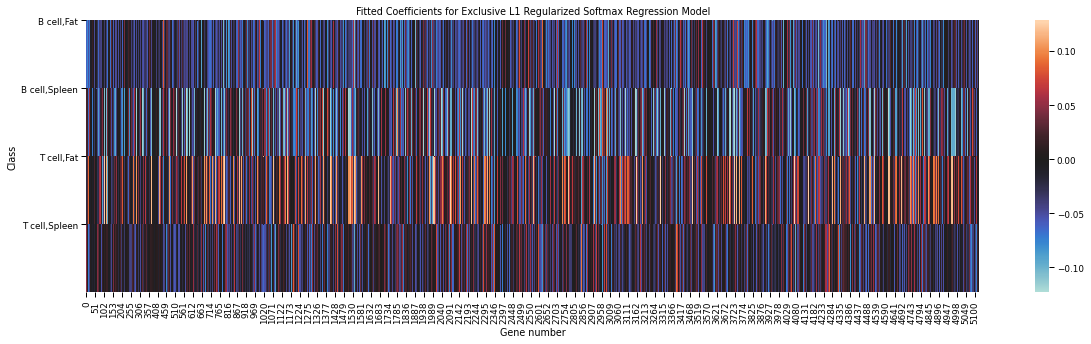

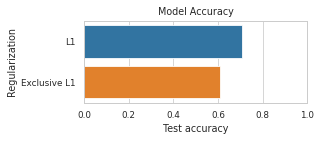

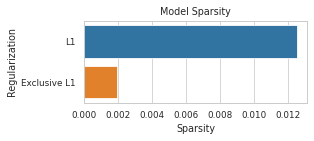

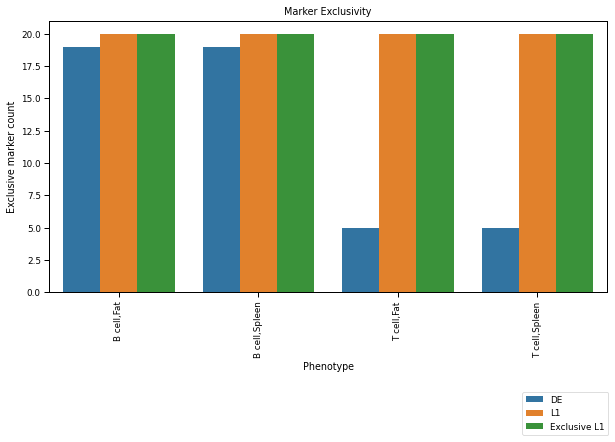

DONE.


In [18]:
run_analysis_pipeline(adata, all_genes_info, result_folder, random_state, cell_types_list=cell_types_list, n_jobs=6, de_markers_df=de_exclusive_df)